# Bird Audio Clips - First Pass Data Exploration

**Project:** Zoo Congo Exhibit Bird Acoustics  
**Data Source:** `data/fl_gaia_zoo_congo_15aug25_data/`  

## 1. Setup Environment and Import Libraries

In [2]:
# Standard data manipulation and analysis
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Audio analysis (will check availability)
try:
    import librosa
    import librosa.display
    AUDIO_AVAILABLE = True
    print("✓ Audio libraries (librosa) available")
except ImportError:
    AUDIO_AVAILABLE = False
    print("⚠ Audio libraries not available - install with: pip install librosa")

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Define base paths
BASE_DIR = Path(r"c:\Users\caspe\Documents\GitHub Private\zoo-acoustics")
DATA_DIR = BASE_DIR / "data" / "fl_gaia_zoo_congo_15aug25_data"
METADATA_FILE = DATA_DIR / "fl_gaia_zoo_congo_15aug25_data_metadata_with_perch.xlsx"

print(f"\nBase directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Metadata file: {METADATA_FILE}")
print(f"\nData directory exists: {DATA_DIR.exists()}")
print(f"Metadata file exists: {METADATA_FILE.exists()}")

✓ Audio libraries (librosa) available

Base directory: c:\Users\caspe\Documents\GitHub Private\zoo-acoustics
Data directory: c:\Users\caspe\Documents\GitHub Private\zoo-acoustics\data\fl_gaia_zoo_congo_15aug25_data
Metadata file: c:\Users\caspe\Documents\GitHub Private\zoo-acoustics\data\fl_gaia_zoo_congo_15aug25_data\fl_gaia_zoo_congo_15aug25_data_metadata_with_perch.xlsx

Data directory exists: True
Metadata file exists: True


## 2. Load and Inspect Metadata

In [3]:
# Load the metadata Excel file
print("Loading metadata...")
metadata_df = pd.read_excel(METADATA_FILE)

print(f"\n{'='*60}")
print(f"METADATA OVERVIEW")
print(f"{'='*60}")
print(f"Total rows: {len(metadata_df):,}")
print(f"Total columns: {len(metadata_df.columns)}")
print(f"\nDataFrame shape: {metadata_df.shape}")

Loading metadata...

METADATA OVERVIEW
Total rows: 78,837
Total columns: 27

DataFrame shape: (78837, 27)


In [4]:
# Display column information
print("\nColumn Information:")
print("-" * 60)
metadata_info = pd.DataFrame({
    'Column': metadata_df.columns,
    'Type': metadata_df.dtypes.values,
    'Non-Null': metadata_df.count().values,
    'Null Count': metadata_df.isnull().sum().values
})
print(metadata_info.to_string(index=False))


Column Information:
------------------------------------------------------------
            Column           Type  Non-Null  Null Count
        Unnamed: 0          int64     78837           0
         sessionId         object     78837           0
              time         object     78837           0
          filename         object     78837           0
               th1        float64     78837           0
         th1_value        float64     78837           0
               th2        float64     78837           0
         th2_value        float64     78837           0
               th3        float64     78837           0
         th3_value        float64     78837           0
            wudate          int64     78837           0
          datetime datetime64[ns]     78837           0
        precipRate          int64     78837           0
       pressureMax        float64     78837           0
          dewptAvg        float64     78837           0
      windgustHigh    

In [5]:
# Display first few rows
print("\nFirst 5 rows of metadata:")
print("=" * 80)
metadata_df.head()


First 5 rows of metadata:


,Unnamed: 0,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,...,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,lon,lat,scientific_name,code,score
0,1,test,_2025_08_08_11_00_02.500000,fl_gaia_zoo_congo_15aug25_data/0/er_file_2025_...,0.219870,0.2,0.877223,0.5,0.549165,0.2,...,22.6,63.1,251,2,283.4,6.06,50.871,Bostrychia hagedash,hadibi1,0.065281
1,2,test,_2025_08_08_11_00_05.250000,fl_gaia_zoo_congo_15aug25_data/0/er_file_2025_...,0.427067,0.2,0.677074,0.5,0.237344,0.2,...,22.6,63.1,251,2,283.4,6.06,50.871,Crotophaga ani,smbani,0.234131
2,3,test,_2025_08_08_11_00_08,fl_gaia_zoo_congo_15aug25_data/0/er_file_2025_...,0.345560,0.2,0.796545,0.5,0.129578,0.2,...,22.6,63.1,251,2,283.4,6.06,50.871,Buteo buteo,combuz1,0.364076
3,4,test,_2025_08_08_11_00_10.750000,fl_gaia_zoo_congo_15aug25_data/0/er_file_2025_...,0.487859,0.2,0.791277,0.5,0.158432,0.2,...,22.6,63.1,251,2,283.4,6.06,50.871,Bradypterus lopezi,camscw1,0.252038
4,5,test,_2025_08_08_11_00_13.500000,fl_gaia_zoo_congo_15aug25_data/0/er_file_2025_...,0.342514,0.2,0.752167,0.5,0.014963,0.2,...,22.6,63.1,251,2,283.4,6.06,50.871,Strix aluco,tawowl1,0.041345


In [6]:
# Display last few rows to see range
print("\nLast 5 rows of metadata:")
print("=" * 80)
metadata_df.tail()


Last 5 rows of metadata:


,Unnamed: 0,sessionId,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,...,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,lon,lat,scientific_name,code,score
78832,78834,test,_2025_08_15_07_54_27,fl_gaia_zoo_congo_15aug25_data/428/er_file_202...,0.343419,0.2,0.777669,0.5,0.134314,0.2,...,18.0,92.0,241,0,61.6,6.06,50.871,Passer montanus,eutspa,0.047836
78833,78835,test,_2025_08_15_07_54_30.250000,fl_gaia_zoo_congo_15aug25_data/428/er_file_202...,0.317056,0.2,0.640220,0.5,0.061497,0.2,...,18.0,92.0,241,0,61.6,6.06,50.871,Coereba flaveola,banana,0.051026
78834,78836,test,_2025_08_15_07_54_42.750000,fl_gaia_zoo_congo_15aug25_data/428/er_file_202...,0.293213,0.2,0.803381,0.5,0.062966,0.2,...,18.0,92.0,241,0,61.6,6.06,50.871,Premnoplex brunnescens,spobar1,0.574086
78835,78837,test,_2025_08_15_07_54_46.250000,fl_gaia_zoo_congo_15aug25_data/428/er_file_202...,0.580275,0.2,0.858570,0.5,0.107660,0.2,...,18.0,92.0,241,0,61.6,6.06,50.871,Sicalis flaveola,saffin,0.011572
78836,78838,test,_2025_08_15_07_55_02.500000,fl_gaia_zoo_congo_15aug25_data/428/er_file_202...,0.308012,0.2,0.844804,0.5,0.140019,0.2,...,18.0,92.0,241,0,61.6,6.06,50.871,Hirundo rustica,barswa,0.331718


## 3. Group Data by Species

Let's identify the species column and analyze the distribution of clips across species.

In [7]:
species_col = 'scientific_name' if 'scientific_name' in metadata_df.columns else None

if species_col:
    print(f"Using '{species_col}' as species identifier\n")
    
    species_summary = metadata_df[species_col].value_counts().reset_index()
    species_summary.columns = ['Species', 'Clip Count']
    species_summary['Percentage'] = (species_summary['Clip Count'] / len(metadata_df) * 100).round(2)
    
    print("="*60)
    print("CLIPS PER SPECIES")
    print("="*60)
    print(species_summary.to_string(index=False))
    print(f"\nTotal unique species: {len(species_summary)}")
else:
    print("⚠ Could not automatically identify species column. Please specify manually.")
    species_summary = None

Using 'scientific_name' as species identifier

CLIPS PER SPECIES
                        Species  Clip Count  Percentage
               Sicalis flaveola        3180        4.03
                Passer montanus        2648        3.36
                Hirundo rustica        2614        3.32
                Toxostoma rufum        2607        3.31
         Ploceus melanocephalus        2500        3.17
                    Strix aluco        1840        2.33
            Rauenia bonariensis        1635        2.07
         Basileuterus rufifrons        1463        1.86
           Brotogeris jugularis        1232        1.56
              Tetrastes bonasia        1177        1.49
               Lanius cristatus        1119        1.42
                      Asio otus        1113        1.41
              Troglodytes aedon        1020        1.29
          Cistothorus palustris         979        1.24
             Hippolais icterina         968        1.23
               Estrilda astrild        

## 4. Scan Audio File Structure

Let's discover all audio files in folders 1-428 and understand the file organization.

In [8]:
# Scan for audio files
print("Scanning audio folders...")
print("This may take a moment for large datasets...\n")

audio_extensions = {'.wav', '.mp3', '.flac', '.ogg', '.m4a'}
audio_files = []

# Scan numbered folders 1-428
for folder_num in range(1, 429):
    folder_path = DATA_DIR / str(folder_num)
    if folder_path.exists():
        # Find all audio files in this folder
        for file_path in folder_path.rglob('*'):
            if file_path.is_file() and file_path.suffix.lower() in audio_extensions:
                audio_files.append({
                    'full_path': str(file_path),
                    'folder_id': folder_num,
                    'filename': file_path.name,
                    'stem': file_path.stem,
                    'extension': file_path.suffix,
                    'relative_path': str(file_path.relative_to(DATA_DIR))
                })

audio_df = pd.DataFrame(audio_files)

print(f"{'='*60}")
print(f"AUDIO FILES DISCOVERED")
print(f"{'='*60}")
print(f"Total audio files found: {len(audio_df):,}")

if len(audio_df) > 0:
    print(f"\nFolders with audio: {audio_df['folder_id'].nunique()}")
    print(f"File extensions: {audio_df['extension'].value_counts().to_dict()}")
    print(f"\nFirst few audio files:")
    display(audio_df.head(10))
else:
    print("\n⚠ No audio files found. Check the folder structure.")

Scanning audio folders...
This may take a moment for large datasets...

AUDIO FILES DISCOVERED
Total audio files found: 42,744

Folders with audio: 428
File extensions: {'.wav': 42744}

First few audio files:


,full_path,folder_id,filename,stem,extension,relative_path
0,c:\Users\caspe\Documents\GitHub Private\zoo-ac...,1,er_file_2025_08_08_11_16_16.250000.wav,er_file_2025_08_08_11_16_16.250000,.wav,1\er_file_2025_08_08_11_16_16.250000.wav
1,c:\Users\caspe\Documents\GitHub Private\zoo-ac...,1,er_file_2025_08_08_11_16_24.250000.wav,er_file_2025_08_08_11_16_24.250000,.wav,1\er_file_2025_08_08_11_16_24.250000.wav
2,c:\Users\caspe\Documents\GitHub Private\zoo-ac...,1,er_file_2025_08_08_11_16_27.wav,er_file_2025_08_08_11_16_27,.wav,1\er_file_2025_08_08_11_16_27.wav
3,c:\Users\caspe\Documents\GitHub Private\zoo-ac...,1,er_file_2025_08_08_11_16_30.500000.wav,er_file_2025_08_08_11_16_30.500000,.wav,1\er_file_2025_08_08_11_16_30.500000.wav
4,c:\Users\caspe\Documents\GitHub Private\zoo-ac...,1,er_file_2025_08_08_11_16_36.wav,er_file_2025_08_08_11_16_36,.wav,1\er_file_2025_08_08_11_16_36.wav
5,c:\Users\caspe\Documents\GitHub Private\zoo-ac...,1,er_file_2025_08_08_11_16_51.250000.wav,er_file_2025_08_08_11_16_51.250000,.wav,1\er_file_2025_08_08_11_16_51.250000.wav
6,c:\Users\caspe\Documents\GitHub Private\zoo-ac...,1,er_file_2025_08_08_11_16_55.250000.wav,er_file_2025_08_08_11_16_55.250000,.wav,1\er_file_2025_08_08_11_16_55.250000.wav
7,c:\Users\caspe\Documents\GitHub Private\zoo-ac...,1,er_file_2025_08_08_11_17_07.750000.wav,er_file_2025_08_08_11_17_07.750000,.wav,1\er_file_2025_08_08_11_17_07.750000.wav
8,c:\Users\caspe\Documents\GitHub Private\zoo-ac...,1,er_file_2025_08_08_11_17_53.500000.wav,er_file_2025_08_08_11_17_53.500000,.wav,1\er_file_2025_08_08_11_17_53.500000.wav
9,c:\Users\caspe\Documents\GitHub Private\zoo-ac...,1,er_file_2025_08_08_11_17_59.wav,er_file_2025_08_08_11_17_59,.wav,1\er_file_2025_08_08_11_17_59.wav


In [9]:
# Analyze folder distribution
if len(audio_df) > 0:
    folder_counts = audio_df['folder_id'].value_counts().sort_index()
    
    print(f"\nAudio files per folder - Summary Statistics:")
    print(f"  Mean: {folder_counts.mean():.1f}")
    print(f"  Median: {folder_counts.median():.1f}")
    print(f"  Min: {folder_counts.min()}")
    print(f"  Max: {folder_counts.max()}")
    
    print(f"\nTop 10 folders by file count:")
    print(folder_counts.head(10))


Audio files per folder - Summary Statistics:
  Mean: 99.9
  Median: 100.0
  Min: 44
  Max: 100

Top 10 folders by file count:
folder_id
1     100
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
Name: count, dtype: int64


## 5. Link Metadata to Audio Files

The metadata contains a 'filename' column with relative paths (from the data directory root) that correspond to the audio .wav files. Let's verify this linkage and construct absolute paths.


In [19]:
# Check if 'filename' column exists in metadata
if 'filename' in metadata_df.columns:
    print("✓ 'filename' column found in metadata\n")
    
    # The metadata 'filename' column contains relative paths from DATA_DIR parent
    # e.g., "fl_gaia_zoo_congo_15aug25_data/0/er_file_2025_08_08_11_00_02.500000.wav"
    # We need to construct full absolute paths
    
    # Convert metadata filename paths to absolute paths
    metadata_df['audio_path'] = metadata_df['filename'].apply(
        lambda x: str(BASE_DIR / "data" / x) if pd.notna(x) else None
    )
    
    # Check which files actually exist
    metadata_df['has_audio'] = metadata_df['audio_path'].apply(
        lambda x: Path(x).exists() if x is not None else False
    )
    
    # Statistics
    matched_count = metadata_df['has_audio'].sum()
    match_rate = (matched_count / len(metadata_df) * 100)
    
    print(f"{'='*60}")
    print(f"METADATA-AUDIO LINKAGE")
    print(f"{'='*60}")
    print(f"Total metadata rows: {len(metadata_df):,}")
    print(f"Metadata rows with audio: {matched_count:,}")
    print(f"Match rate: {match_rate:.2f}%")
    print(f"\nUnmatched metadata rows: {len(metadata_df) - matched_count:,}")
    
    # Show examples of matched and unmatched
    print(f"\n{'='*60}")
    print(f"MATCHED EXAMPLES (first 5):")
    print(f"{'='*60}")
    matched_samples = metadata_df[metadata_df['has_audio']].head()
    for idx, row in matched_samples.iterrows():
        print(f"  {row['filename']}")
        print(f"    -> {row['audio_path']}")
    
    if (len(metadata_df) - matched_count) > 0:
        print(f"\n{'='*60}")
        print(f"UNMATCHED EXAMPLES (first 5):")
        print(f"{'='*60}")
        unmatched_samples = metadata_df[~metadata_df['has_audio']].head()
        for idx, row in unmatched_samples.iterrows():
            print(f"  {row['filename']}")
            if pd.notna(row['audio_path']):
                print(f"    Expected at: {row['audio_path']}")
else:
    print("⚠ 'filename' column not found in metadata")
    print(f"Available columns: {list(metadata_df.columns)}")


✓ 'filename' column found in metadata

METADATA-AUDIO LINKAGE
Total metadata rows: 78,837
Metadata rows with audio: 78,837
Match rate: 100.00%

Unmatched metadata rows: 0

MATCHED EXAMPLES (first 5):
  fl_gaia_zoo_congo_15aug25_data/0/er_file_2025_08_08_11_00_02.500000.wav
    -> c:\Users\caspe\Documents\GitHub Private\zoo-acoustics\data\fl_gaia_zoo_congo_15aug25_data\0\er_file_2025_08_08_11_00_02.500000.wav
  fl_gaia_zoo_congo_15aug25_data/0/er_file_2025_08_08_11_00_05.250000.wav
    -> c:\Users\caspe\Documents\GitHub Private\zoo-acoustics\data\fl_gaia_zoo_congo_15aug25_data\0\er_file_2025_08_08_11_00_05.250000.wav
  fl_gaia_zoo_congo_15aug25_data/0/er_file_2025_08_08_11_00_08.wav
    -> c:\Users\caspe\Documents\GitHub Private\zoo-acoustics\data\fl_gaia_zoo_congo_15aug25_data\0\er_file_2025_08_08_11_00_08.wav
  fl_gaia_zoo_congo_15aug25_data/0/er_file_2025_08_08_11_00_10.750000.wav
    -> c:\Users\caspe\Documents\GitHub Private\zoo-acoustics\data\fl_gaia_zoo_congo_15aug25_data\0\er_fi

## 6. Preliminary Data Analysis

Now that we've linked metadata to audio files, let's explore the key columns and their relationships.

### 6.1 Species Detection Analysis

Analyze the PERCH model predictions: scientific_name, code (species code), and confidence scores.

In [20]:
# Analyze species detections and confidence scores
print("="*70)
print("SPECIES DETECTION SUMMARY")
print("="*70)

# Basic stats on detections
print(f"\nTotal clips analyzed: {len(metadata_df):,}")
print(f"Clips with species detected: {metadata_df['scientific_name'].notna().sum():,}")
print(f"Clips without detection: {metadata_df['scientific_name'].isna().sum():,}")

# Score distribution
if 'score' in metadata_df.columns:
    print(f"\nConfidence Score Statistics:")
    print(f"  Mean: {metadata_df['score'].mean():.3f}")
    print(f"  Median: {metadata_df['score'].median():.3f}")
    print(f"  Min: {metadata_df['score'].min():.3f}")
    print(f"  Max: {metadata_df['score'].max():.3f}")
    print(f"  Std Dev: {metadata_df['score'].std():.3f}")
    
    # Score distribution by quartile
    print(f"\nScore Quartiles:")
    for q in [0.25, 0.50, 0.75, 0.90, 0.95, 0.99]:
        val = metadata_df['score'].quantile(q)
        print(f"  {int(q*100)}th percentile: {val:.3f}")

# Top species by detection count
print(f"\n{'='*70}")
print(f"TOP 10 DETECTED SPECIES (by count)")
print(f"{'='*70}")
top_species = metadata_df['scientific_name'].value_counts().head(10).reset_index()
top_species.columns = ['Species', 'Count']
top_species['Percentage'] = (top_species['Count'] / len(metadata_df) * 100).round(2)
print(top_species.to_string(index=False))

# Average confidence score by species
if 'score' in metadata_df.columns:
    print(f"\n{'='*70}")
    print(f"AVERAGE CONFIDENCE SCORE BY SPECIES (Top 10 by count)")
    print(f"{'='*70}")
    species_scores = metadata_df.groupby('scientific_name')['score'].agg(['mean', 'count', 'std']).sort_values('count', ascending=False).head(10)
    species_scores.columns = ['Avg Score', 'Count', 'Std Dev']
    species_scores['Avg Score'] = species_scores['Avg Score'].round(3)
    species_scores['Std Dev'] = species_scores['Std Dev'].round(3)
    print(species_scores)

SPECIES DETECTION SUMMARY

Total clips analyzed: 78,837
Clips with species detected: 78,837
Clips without detection: 0

Confidence Score Statistics:
  Mean: 0.168
  Median: 0.089
  Min: 0.000
  Max: 1.000
  Std Dev: 0.197

Score Quartiles:
  25th percentile: 0.041
  50th percentile: 0.089
  75th percentile: 0.212
  90th percentile: 0.446
  95th percentile: 0.632
  99th percentile: 0.906

TOP 10 DETECTED SPECIES (by count)
               Species  Count  Percentage
      Sicalis flaveola   3180        4.03
       Passer montanus   2648        3.36
       Hirundo rustica   2614        3.32
       Toxostoma rufum   2607        3.31
Ploceus melanocephalus   2500        3.17
           Strix aluco   1840        2.33
   Rauenia bonariensis   1635        2.07
Basileuterus rufifrons   1463        1.86
  Brotogeris jugularis   1232        1.56
     Tetrastes bonasia   1177        1.49

AVERAGE CONFIDENCE SCORE BY SPECIES (Top 10 by count)
                        Avg Score  Count  Std Dev
scienti

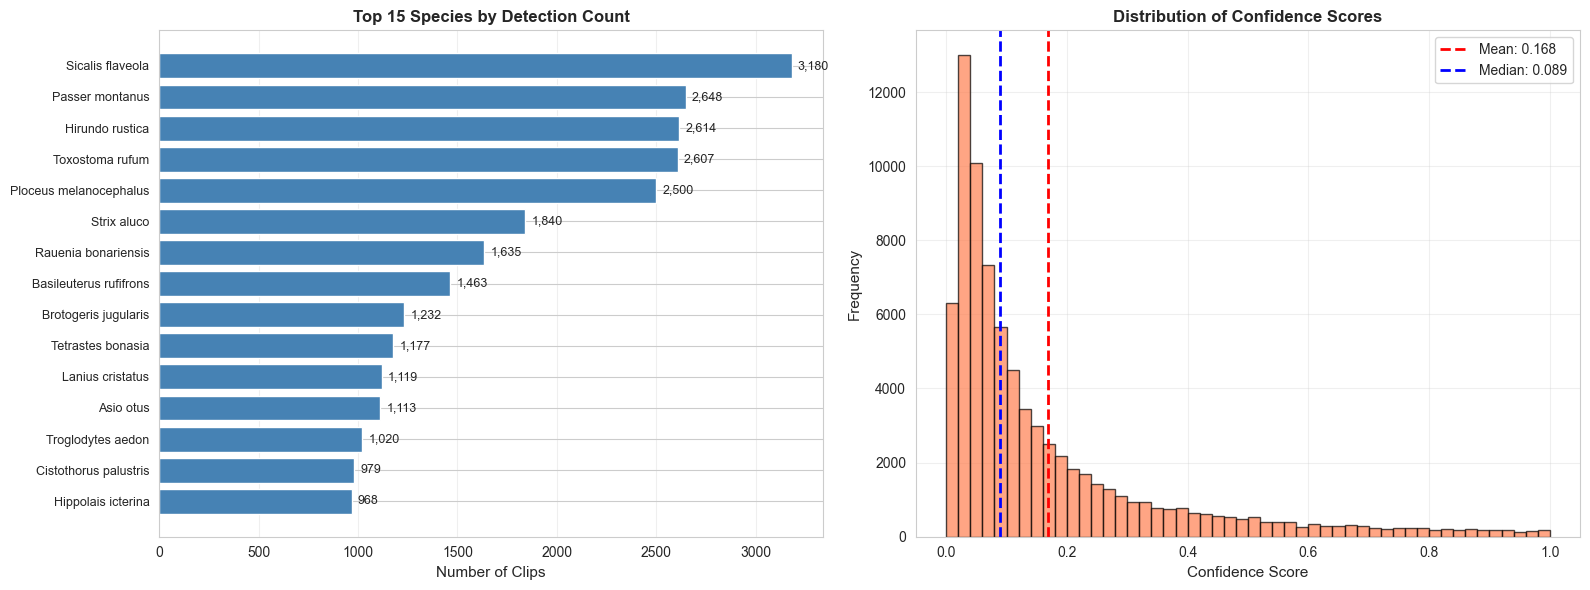

In [21]:
# Visualize species distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of top species
top_n = 15
top_species_plot = metadata_df['scientific_name'].value_counts().head(top_n)
axes[0].barh(range(len(top_species_plot)), top_species_plot.values, color='steelblue')
axes[0].set_yticks(range(len(top_species_plot)))
axes[0].set_yticklabels(top_species_plot.index, fontsize=9)
axes[0].set_xlabel('Number of Clips', fontsize=11)
axes[0].set_title(f'Top {top_n} Species by Detection Count', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add count labels
for i, v in enumerate(top_species_plot.values):
    axes[0].text(v + max(top_species_plot.values)*0.01, i, f'{v:,}', va='center', fontsize=9)

# Score distribution histogram
if 'score' in metadata_df.columns:
    axes[1].hist(metadata_df['score'].dropna(), bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[1].axvline(metadata_df['score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {metadata_df["score"].mean():.3f}')
    axes[1].axvline(metadata_df['score'].median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {metadata_df["score"].median():.3f}')
    axes[1].set_xlabel('Confidence Score', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title('Distribution of Confidence Scores', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2 Temporal Analysis

Explore temporal patterns in the recordings using the datetime column.

In [22]:
# Convert datetime column to datetime type if not already
if 'datetime' in metadata_df.columns:
    metadata_df['datetime_parsed'] = pd.to_datetime(metadata_df['datetime'], errors='coerce')
    
    # Extract time components
    metadata_df['date'] = metadata_df['datetime_parsed'].dt.date
    metadata_df['hour'] = metadata_df['datetime_parsed'].dt.hour
    metadata_df['day_of_week'] = metadata_df['datetime_parsed'].dt.day_name()
    metadata_df['month'] = metadata_df['datetime_parsed'].dt.month
    metadata_df['month_name'] = metadata_df['datetime_parsed'].dt.month_name()
    
    print("="*70)
    print("TEMPORAL COVERAGE")
    print("="*70)
    print(f"Date range: {metadata_df['datetime_parsed'].min()} to {metadata_df['datetime_parsed'].max()}")
    print(f"Total days covered: {metadata_df['date'].nunique():,}")
    print(f"Total clips: {len(metadata_df):,}")
    print(f"Average clips per day: {len(metadata_df) / metadata_df['date'].nunique():.1f}")
    
    # Hourly distribution
    print(f"\n{'='*70}")
    print(f"RECORDINGS BY HOUR OF DAY")
    print(f"{'='*70}")
    hourly_counts = metadata_df['hour'].value_counts().sort_index()
    for hour, count in hourly_counts.items():
        bar_length = int(count / hourly_counts.max() * 40)
        bar = '█' * bar_length
        print(f"{hour:02d}:00  {bar} {count:,}")
    
    # Daily distribution
    print(f"\n{'='*70}")
    print(f"RECORDINGS BY DAY OF WEEK")
    print(f"{'='*70}")
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts = metadata_df['day_of_week'].value_counts().reindex(day_order, fill_value=0)
    for day, count in day_counts.items():
        bar_length = int(count / day_counts.max() * 40)
        bar = '█' * bar_length
        print(f"{day:10s}  {bar} {count:,}")
else:
    print("⚠ 'datetime' column not found in metadata")

TEMPORAL COVERAGE
Date range: 2025-08-08 11:00:02 to 2025-08-15 07:55:02
Total days covered: 8
Total clips: 78,837
Average clips per day: 9854.6

RECORDINGS BY HOUR OF DAY
00:00  ██ 412
01:00  █████████ 1,328
02:00  ██████████████ 2,185
03:00  █████████ 1,373
04:00  ███████████████████████████████████ 5,222
05:00  ████████████████████████████████████████ 5,857
06:00  ██████████████████████████████████ 5,025
07:00  ███████████████████████████████ 4,670
08:00  █████████████████████████ 3,665
09:00  ████████████████████████ 3,631
10:00  ██████████████████████████ 3,903
11:00  ██████████████████████████████ 4,534
12:00  ██████████████████████████████ 4,459
13:00  ██████████████████████████████ 4,511
14:00  ██████████████████████████████ 4,517
15:00  ██████████████████████████████ 4,529
16:00  ███████████████████████████████ 4,565
17:00  █████████████████████████████████ 4,865
18:00  ███████████████████████████████ 4,653
19:00  ███████████████████████ 3,369
20:00  ████ 611
21:00  █ 268
22:0

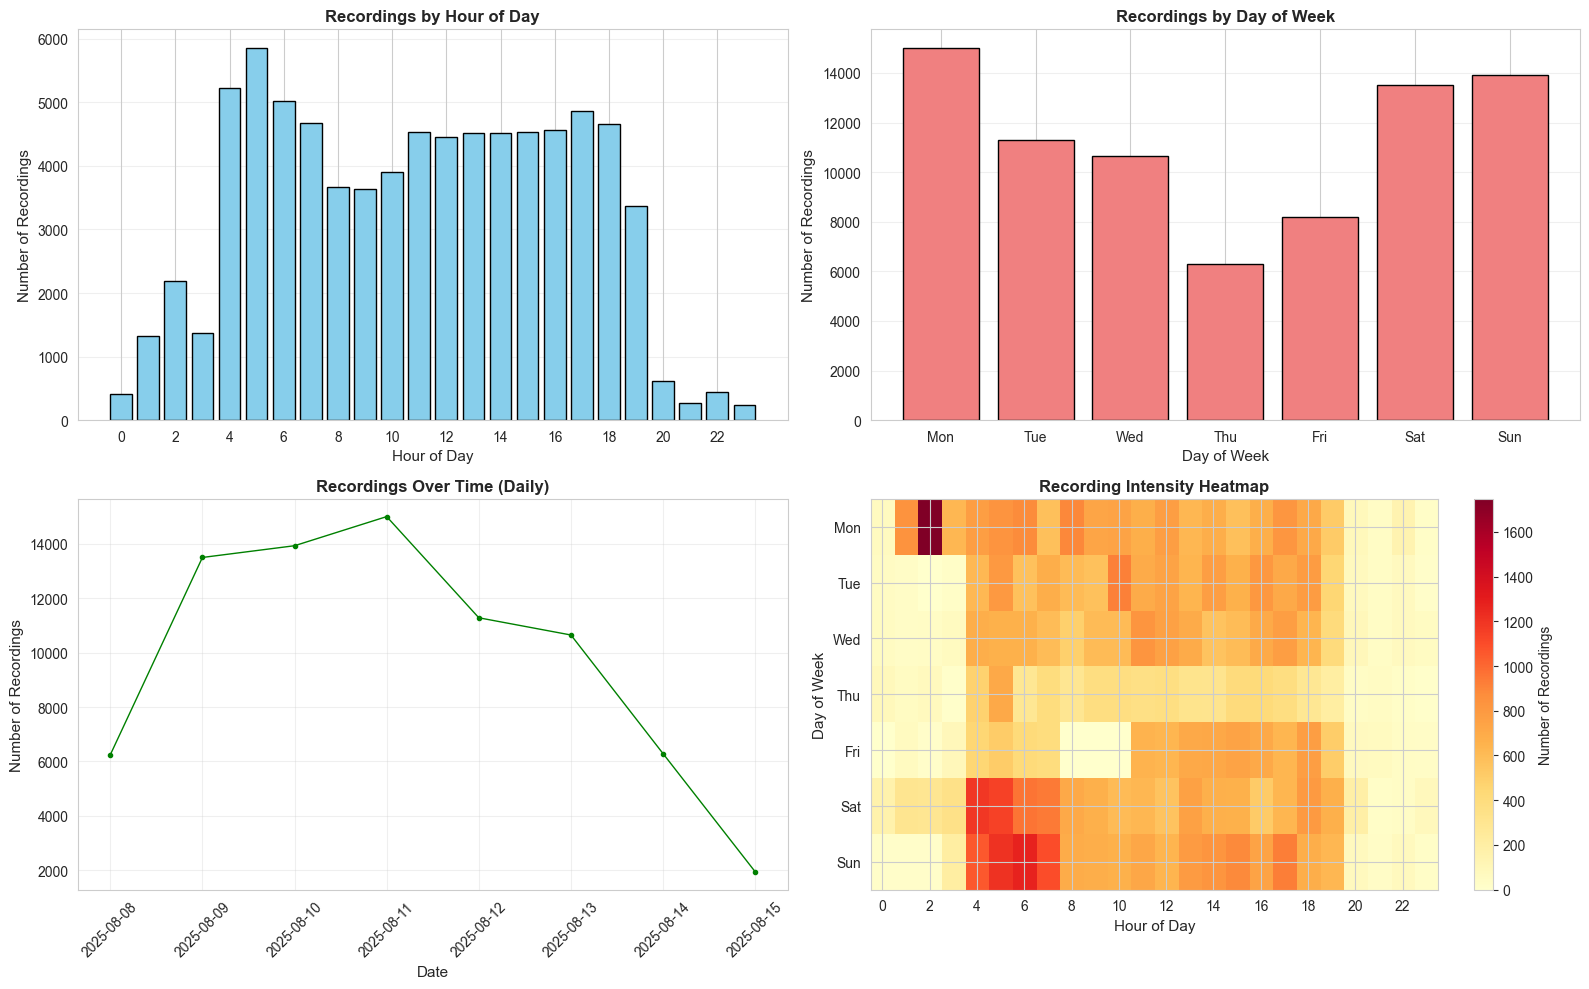

In [23]:
# Visualize temporal patterns
if 'datetime_parsed' in metadata_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Hour of day distribution
    hourly_counts = metadata_df['hour'].value_counts().sort_index()
    axes[0, 0].bar(hourly_counts.index, hourly_counts.values, color='skyblue', edgecolor='black')
    axes[0, 0].set_xlabel('Hour of Day', fontsize=11)
    axes[0, 0].set_ylabel('Number of Recordings', fontsize=11)
    axes[0, 0].set_title('Recordings by Hour of Day', fontsize=12, fontweight='bold')
    axes[0, 0].set_xticks(range(0, 24, 2))
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Day of week distribution
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts = metadata_df['day_of_week'].value_counts().reindex(day_order, fill_value=0)
    axes[0, 1].bar(range(len(day_counts)), day_counts.values, color='lightcoral', edgecolor='black')
    axes[0, 1].set_xticks(range(len(day_counts)))
    axes[0, 1].set_xticklabels([d[:3] for d in day_order], fontsize=10)
    axes[0, 1].set_xlabel('Day of Week', fontsize=11)
    axes[0, 1].set_ylabel('Number of Recordings', fontsize=11)
    axes[0, 1].set_title('Recordings by Day of Week', fontsize=12, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Daily timeline
    daily_counts = metadata_df.groupby('date').size()
    axes[1, 0].plot(daily_counts.index, daily_counts.values, marker='o', linewidth=1, markersize=3, color='green')
    axes[1, 0].set_xlabel('Date', fontsize=11)
    axes[1, 0].set_ylabel('Number of Recordings', fontsize=11)
    axes[1, 0].set_title('Recordings Over Time (Daily)', fontsize=12, fontweight='bold')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(alpha=0.3)
    
    # Heatmap: Hour vs Day of Week
    pivot_data = metadata_df.groupby(['day_of_week', 'hour']).size().reset_index(name='count')
    pivot_table = pivot_data.pivot(index='day_of_week', columns='hour', values='count').fillna(0)
    pivot_table = pivot_table.reindex(day_order)
    
    im = axes[1, 1].imshow(pivot_table.values, cmap='YlOrRd', aspect='auto')
    axes[1, 1].set_xticks(range(0, 24, 2))
    axes[1, 1].set_xticklabels(range(0, 24, 2))
    axes[1, 1].set_yticks(range(len(day_order)))
    axes[1, 1].set_yticklabels([d[:3] for d in day_order])
    axes[1, 1].set_xlabel('Hour of Day', fontsize=11)
    axes[1, 1].set_ylabel('Day of Week', fontsize=11)
    axes[1, 1].set_title('Recording Intensity Heatmap', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[1, 1])
    cbar.set_label('Number of Recordings', fontsize=10)
    
    plt.tight_layout()
    plt.show()

### 6.3 Weather Conditions Analysis

Explore how weather conditions relate to bird activity and detection rates.

In [24]:
# Analyze weather variables
weather_cols = ['tempAve', 'humidityAvg', 'precipRate', 'windspeedAvg', 
                'pressureMax', 'dewptAvg', 'solarRadiationHigh', 'uvHigh']

# Check which weather columns exist
available_weather = [col for col in weather_cols if col in metadata_df.columns]

if available_weather:
    print("="*70)
    print("WEATHER CONDITIONS SUMMARY")
    print("="*70)
    
    for col in available_weather:
        data = metadata_df[col].dropna()
        if len(data) > 0:
            print(f"\n{col}:")
            print(f"  Mean: {data.mean():.2f}")
            print(f"  Median: {data.median():.2f}")
            print(f"  Min: {data.min():.2f}")
            print(f"  Max: {data.max():.2f}")
            print(f"  Std Dev: {data.std():.2f}")
            print(f"  Missing: {metadata_df[col].isna().sum():,} ({metadata_df[col].isna().sum()/len(metadata_df)*100:.1f}%)")
else:
    print("⚠ No weather columns found in metadata")

# Correlation between weather and detection confidence
if available_weather and 'score' in metadata_df.columns:
    print(f"\n{'='*70}")
    print(f"CORRELATION: Weather vs. Detection Confidence Score")
    print(f"{'='*70}")
    
    correlations = []
    for col in available_weather:
        if metadata_df[col].notna().sum() > 0:
            corr = metadata_df[[col, 'score']].corr().iloc[0, 1]
            correlations.append({'Weather Variable': col, 'Correlation': corr})
    
    if correlations:
        corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)
        corr_df['Correlation'] = corr_df['Correlation'].round(3)
        print(corr_df.to_string(index=False))

WEATHER CONDITIONS SUMMARY

tempAve:
  Mean: 23.72
  Median: 25.00
  Min: 11.10
  Max: 38.30
  Std Dev: 7.56
  Missing: 0 (0.0%)

humidityAvg:
  Mean: 63.30
  Median: 61.70
  Min: 29.40
  Max: 95.00
  Std Dev: 22.38
  Missing: 0 (0.0%)

precipRate:
  Mean: 0.00
  Median: 0.00
  Min: 0.00
  Max: 0.00
  Std Dev: 0.00
  Missing: 0 (0.0%)

windspeedAvg:
  Mean: 0.47
  Median: 0.20
  Min: 0.00
  Max: 4.90
  Std Dev: 0.63
  Missing: 0 (0.0%)

pressureMax:
  Mean: 1027.42
  Median: 1026.52
  Min: 1019.64
  Max: 1035.32
  Std Dev: 4.30
  Missing: 0 (0.0%)

dewptAvg:
  Mean: 15.13
  Median: 15.00
  Min: 10.10
  Max: 21.70
  Std Dev: 2.91
  Missing: 0 (0.0%)

solarRadiationHigh:
  Mean: 237.40
  Median: 193.80
  Min: 0.00
  Max: 737.40
  Std Dev: 221.23
  Missing: 0 (0.0%)

uvHigh:
  Mean: 1.95
  Median: 1.00
  Min: 0.00
  Max: 7.00
  Std Dev: 2.02
  Missing: 0 (0.0%)

CORRELATION: Weather vs. Detection Confidence Score
  Weather Variable  Correlation
           tempAve        0.017
          de

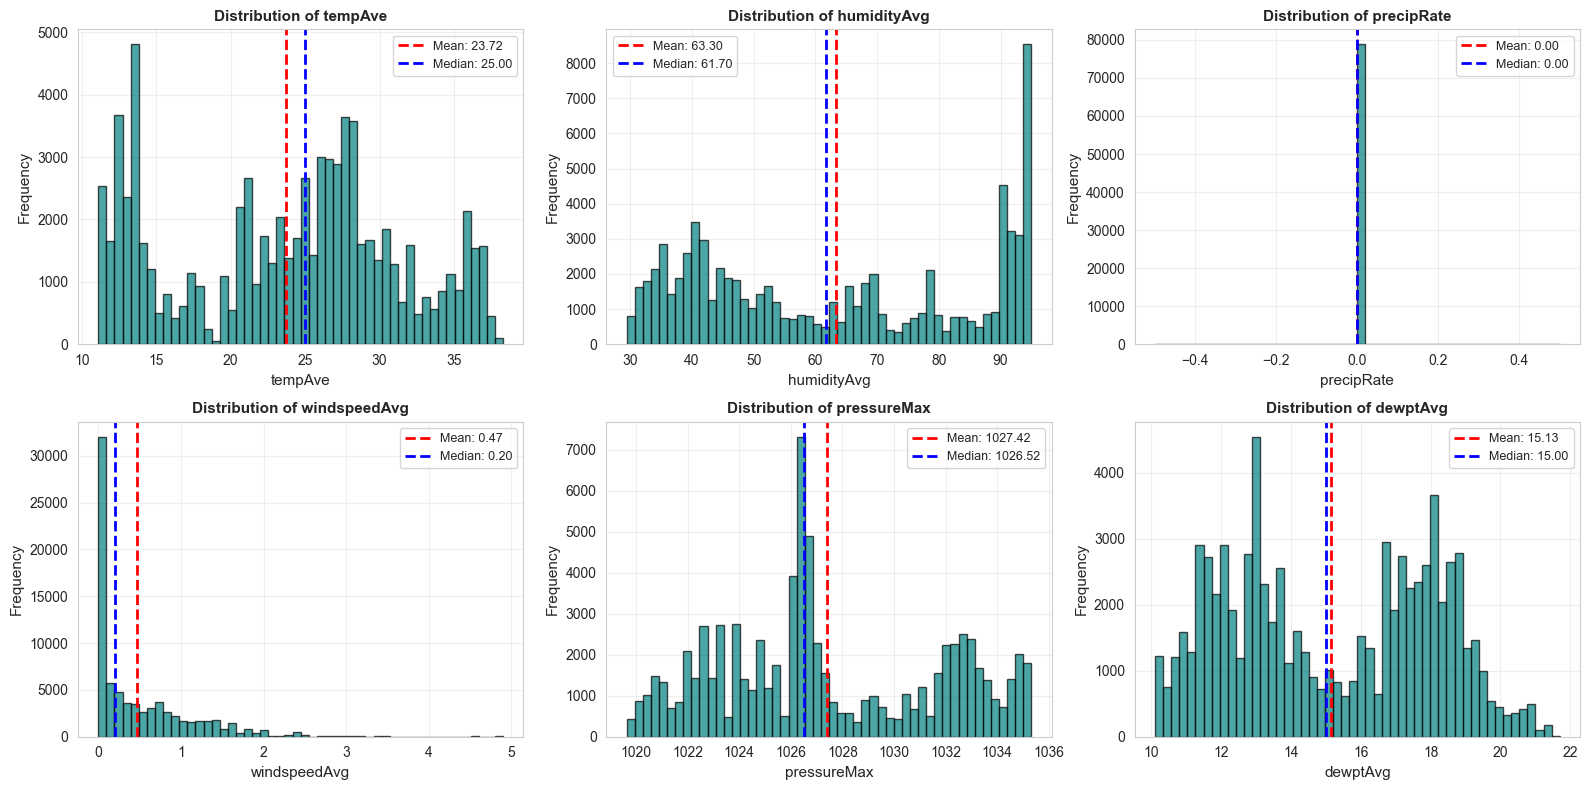

In [25]:
# Visualize weather conditions
if available_weather:
    # Select up to 6 key weather variables for visualization
    plot_weather = available_weather[:6]
    n_plots = len(plot_weather)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
    axes = axes.flatten() if n_plots > 1 else [axes]
    
    for idx, col in enumerate(plot_weather):
        data = metadata_df[col].dropna()
        if len(data) > 0:
            axes[idx].hist(data, bins=50, color='teal', alpha=0.7, edgecolor='black')
            axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, 
                            label=f'Mean: {data.mean():.2f}')
            axes[idx].axvline(data.median(), color='blue', linestyle='--', linewidth=2,
                            label=f'Median: {data.median():.2f}')
            axes[idx].set_xlabel(col, fontsize=11)
            axes[idx].set_ylabel('Frequency', fontsize=11)
            axes[idx].set_title(f'Distribution of {col}', fontsize=11, fontweight='bold')
            axes[idx].legend(fontsize=9)
            axes[idx].grid(alpha=0.3)
    
    # Hide empty subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

### 6.4 Species Activity Patterns

Analyze when different species are most active throughout the day.

In [26]:
# Analyze species activity by time of day
if 'hour' in metadata_df.columns and 'scientific_name' in metadata_df.columns:
    
    # Get top 5 most common species
    top_5_species = metadata_df['scientific_name'].value_counts().head(5).index.tolist()
    
    print("="*70)
    print("SPECIES ACTIVITY BY HOUR (Top 5 Species)")
    print("="*70)
    
    # Create pivot table: species x hour
    species_hour = metadata_df[metadata_df['scientific_name'].isin(top_5_species)].groupby(
        ['scientific_name', 'hour']).size().reset_index(name='count')
    
    for species in top_5_species:
        print(f"\n{species}:")
        species_data = species_hour[species_hour['scientific_name'] == species]
        total_detections = species_data['count'].sum()
        
        for _, row in species_data.sort_values('hour').iterrows():
            hour = int(row['hour'])
            count = int(row['count'])
            pct = (count / total_detections * 100)
            bar_length = int(pct / 2)  # Scale to fit
            bar = '█' * bar_length
            print(f"  {hour:02d}:00  {bar} {count:4d} ({pct:5.1f}%)")

SPECIES ACTIVITY BY HOUR (Top 5 Species)

Sicalis flaveola:
  04:00  ████████  512 ( 16.1%)
  05:00  ██████  412 ( 13.0%)
  06:00  █████  333 ( 10.5%)
  07:00  ███  210 (  6.6%)
  08:00  ███  242 (  7.6%)
  09:00  █  121 (  3.8%)
  10:00  █  103 (  3.2%)
  11:00  █   97 (  3.1%)
  12:00     60 (  1.9%)
  13:00  █   94 (  3.0%)
  14:00  █  127 (  4.0%)
  15:00  ███  210 (  6.6%)
  16:00  ███  195 (  6.1%)
  17:00  ██  143 (  4.5%)
  18:00  ████  270 (  8.5%)
  19:00     51 (  1.6%)

Passer montanus:
  03:00      2 (  0.1%)
  04:00  ███  203 (  7.7%)
  05:00  ████  264 ( 10.0%)
  06:00  ██████  325 ( 12.3%)
  07:00  ██████  333 ( 12.6%)
  08:00  ███  175 (  6.6%)
  09:00     52 (  2.0%)
  10:00     41 (  1.5%)
  11:00     38 (  1.4%)
  12:00     34 (  1.3%)
  13:00  █   61 (  2.3%)
  14:00  █   60 (  2.3%)
  15:00  ██  129 (  4.9%)
  16:00  ███  174 (  6.6%)
  17:00  █████  316 ( 11.9%)
  18:00  █████  301 ( 11.4%)
  19:00  ██  129 (  4.9%)
  20:00      4 (  0.2%)
  22:00      5 (  0.2%)

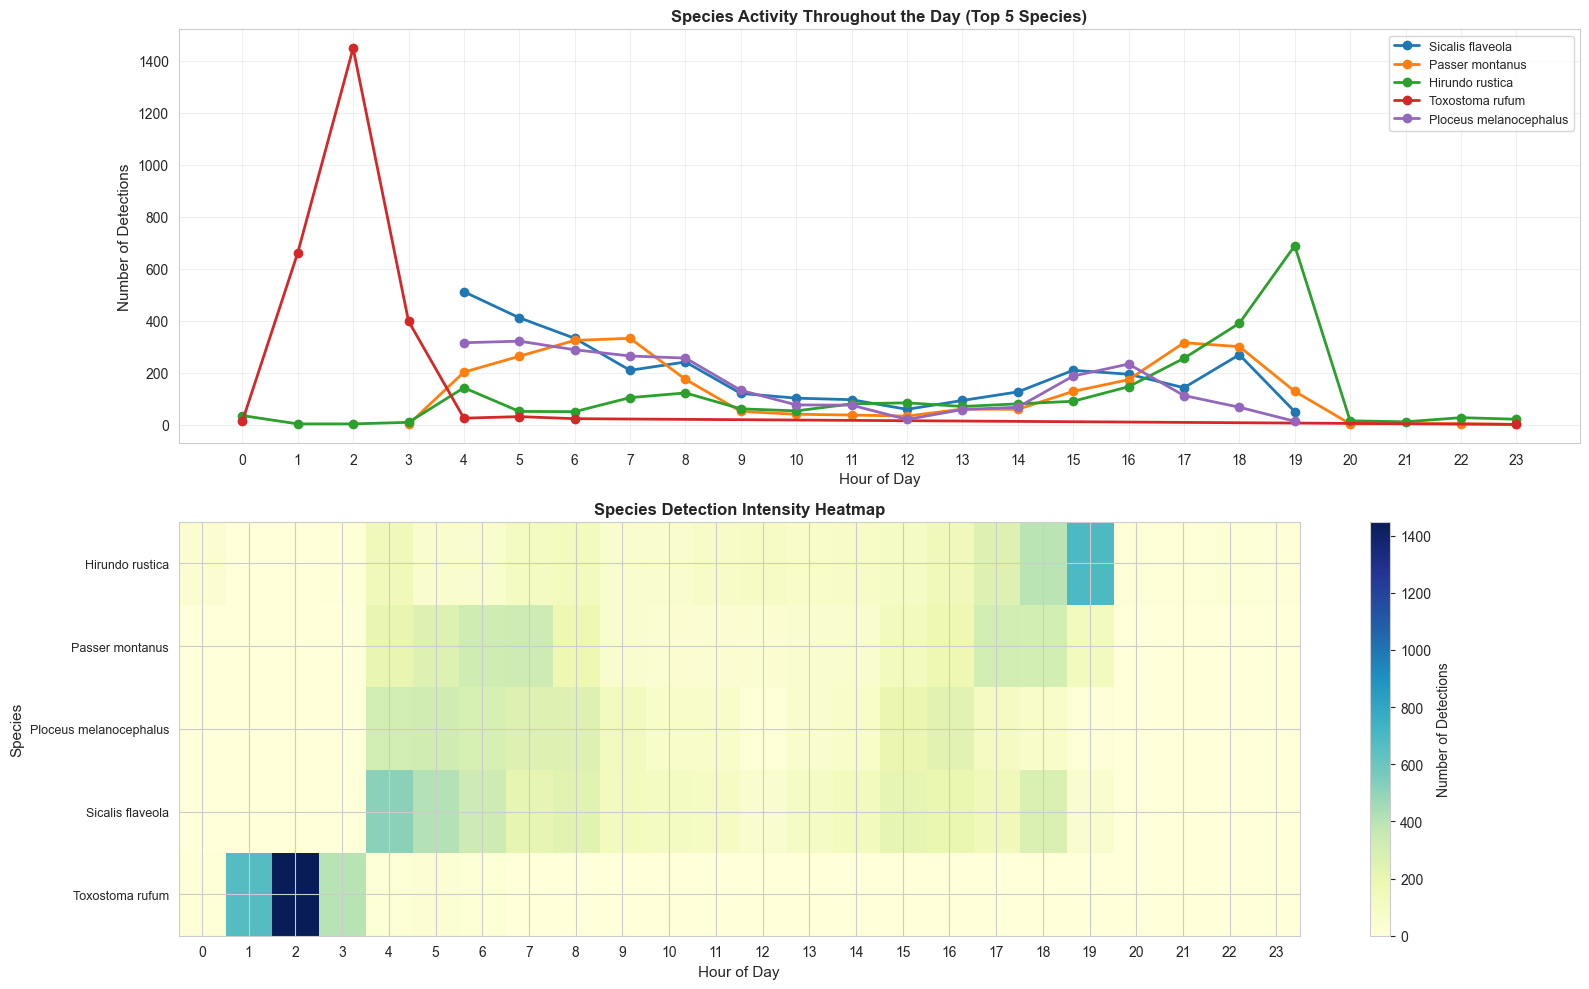

In [27]:
# Visualize species activity patterns
if 'hour' in metadata_df.columns and 'scientific_name' in metadata_df.columns:
    
    top_5_species = metadata_df['scientific_name'].value_counts().head(5).index.tolist()
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Line plot: Activity by hour for top species
    for species in top_5_species:
        species_hourly = metadata_df[metadata_df['scientific_name'] == species].groupby('hour').size()
        axes[0].plot(species_hourly.index, species_hourly.values, marker='o', linewidth=2, 
                    label=species, markersize=6)
    
    axes[0].set_xlabel('Hour of Day', fontsize=11)
    axes[0].set_ylabel('Number of Detections', fontsize=11)
    axes[0].set_title('Species Activity Throughout the Day (Top 5 Species)', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=9, loc='best')
    axes[0].set_xticks(range(0, 24))
    axes[0].grid(alpha=0.3)
    
    # Heatmap: Species vs Hour
    pivot_data = metadata_df[metadata_df['scientific_name'].isin(top_5_species)].groupby(
        ['scientific_name', 'hour']).size().reset_index(name='count')
    pivot_table = pivot_data.pivot(index='scientific_name', columns='hour', values='count').fillna(0)
    
    im = axes[1].imshow(pivot_table.values, cmap='YlGnBu', aspect='auto')
    axes[1].set_xticks(range(24))
    axes[1].set_xticklabels(range(24))
    axes[1].set_yticks(range(len(pivot_table.index)))
    axes[1].set_yticklabels(pivot_table.index, fontsize=9)
    axes[1].set_xlabel('Hour of Day', fontsize=11)
    axes[1].set_ylabel('Species', fontsize=11)
    axes[1].set_title('Species Detection Intensity Heatmap', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[1])
    cbar.set_label('Number of Detections', fontsize=10)
    
    plt.tight_layout()
    plt.show()